# Retreiving dnBC from cellBC based on reamplifed reads

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from kneed import DataGenerator, KneeLocator
import numpy as np
from Bio.Seq import Seq
import subprocess
from kneed import DataGenerator, KneeLocator

In [2]:
#make a list of UMI, cellBC, and dnBC
def retreiveBC(inputfile):
    with open(inputfile, 'r') as f:
        cellBCupBCdict = {'cellBC':[], 'UMI' :[], 'dnBC':[]}
        while True:
            try:
                line = next(f)
                cellBCupBCdict['cellBC'].append(line[31:47])
                cellBCupBCdict['UMI'].append(line[47:57])
                cellBCupBCdict['dnBC'].append(line[0:30])
            except StopIteration:
                f.close()
                return pd.DataFrame(cellBCupBCdict)

In [3]:
retreiveBCpd=retreiveBC('BClibsplit.csv')
retreiveBCpd

,cellBC,UMI,dnBC
0,CGAGTGCAGTGCAACG,TTTATCTTGT,CCGCCCAAAGAGAAATAGACACAAAAGAGG
1,ATCGTAGGTCCTGATT,TTCATATGCG,AGAAAAACACCCTAAACGAGTCACAACCAC
2,TCACTCGTCACGGACC,AGATTAGCTA,AACTTTTCCAGTAACCCCCACCCCACACAA
3,GAGTTTGTCGATTGAC,TGTCTTCTGT,GGGAGGCTTATCCAACACTAATTCTATTAC
4,CTCTGGTTCGGCGATC,ACAATACTAA,AGATATCACAGAACCCGAAACGACACGGAC
...,...,...,...
405137,TGAGTCAAGCCTTTGA,TGTTAGACTC,TAATCCACAACATGACGCACCACACCGCCC
405138,CCTCTAGTCCTCTTTC,CTCCTGACGT,AGAAAAACACCCTAAACGAGTCACAACCAC
405139,GCCAGTGTCCCAGTGG,TAACAAGCAC,CATTATACGAAGATTAAGAATACCCACCAC
405140,CGAATTGCATGAATAG,CCTCTTTTGT,GAGCAAGATCACCTAACGCATATGAACGAG


In [4]:
#all possibe dnBC per cellBC
def cellBCdnBClt(cellBCdnBCtable):
    countdnBC = retreiveBCpd.groupby('cellBC')['dnBC'].value_counts()
    countdnBC.to_csv('cellbc_dnbc_count.csv', header = ['count'])
    print('cellBC dnBC list stored as : "cellbc_dnbc_count.csv"')
    return 

cellBCdnBClt(retreiveBCpd)


cellBC dnBC list stored as : "cellbc_dnbc_count.csv"


Previously, simply chose dnBC with highest read count

In [5]:
# only dnBC with highet read count
def cellBCdnBCmin(countcsv):
    countdnBC = pd.read_csv('cellbc_dnbc_count.csv')
    cellBCdnBCmin = countdnBC.loc[countdnBC.groupby('cellBC')['count'].idxmax()].sort_values('count', ascending = False)
    def revcomp(row):
        seq = Seq(row['dnBC'])
        revseq = str(seq.reverse_complement())
        return revseq
    cellBCdnBCmin['dnBC'] = cellBCdnBCmin.apply(revcomp, axis=1)
    cellBCdnBCmin.to_csv('cellbc_topdnbc_count.csv')
    print('cellBC TOPdnBC list stored as : "cellbc_topdnbc_count.csv"')
    return cellBCdnBCmin

cellBCdnBCmin = cellBCdnBCmin('cellbc_dnbc_count.csv')
cellBCdnBCmin

cellBC TOPdnBC list stored as : "cellbc_topdnbc_count.csv"


,cellBC,dnBC,count
26415,CATCCGTCATGCCGAC,GTGGTTGTGACTCGTTTAGGGTGTTTTTCT,536
49875,GCAGCCAAGTGTTGTC,GTGGTTGTGACTCGTTTAGGGTGTTTTTCT,507
33678,CGCAGGTGTGCGAGTA,GTGGTTGTGACTCGTTTAGGGTGTTTTTCT,471
416,AAAGGGCAGTTGCGCC,GTGGTTGTGACTCGTTTAGGGTGTTTTTCT,453
17956,ATCGTAGCAAAGAACT,GTGGTTGTGACTCGTTTAGGGTGTTTTTCT,440
...,...,...,...
34176,CGCCGGATCTCAGAAC,CTCCGTGGTGGGTTTTGTCCTTTACGCTCT,1
34175,CGCCGATGTGACGTCC,GTGGTTGTGACTCGTTTAGGGTGTTTTTCT,1
34174,CGCCCTCTCTCCTCCC,CTCCGTGGTGGGTTTTGTCCTTTACGCTCT,1
34173,CGCCATTTCGCACGGT,GTGGTTGTGACTCGTTTAGGGTGTTTTTCT,1


Computed the frequency of each down barcode per cell barcode

In [6]:
#make df for counts
countdnBC = retreiveBCpd.groupby('cellBC')['dnBC'].value_counts().to_frame().rename(columns={"dnBC": "count"}).reset_index()

#df for frequency 
nordnBC = retreiveBCpd.groupby('cellBC')['dnBC'].value_counts(normalize = True).to_frame().rename(columns={"dnBC": "freq"}).reset_index()

#merge
merged_data= countdnBC.merge(nordnBC, on=['cellBC','dnBC'])

#need to do reverse complement
def revcomp(row):
    seq = Seq(row['dnBC'])
    revseq = str(seq.reverse_complement())
    return revseq
merged_data['dnBC'] = merged_data.apply(revcomp, axis=1)

merged_data.sort_values('count', ascending = False)

,cellBC,dnBC,count,freq
26415,CATCCGTCATGCCGAC,GTGGTTGTGACTCGTTTAGGGTGTTTTTCT,536,0.628370
49875,GCAGCCAAGTGTTGTC,GTGGTTGTGACTCGTTTAGGGTGTTTTTCT,507,0.816425
33678,CGCAGGTGTGCGAGTA,GTGGTTGTGACTCGTTTAGGGTGTTTTTCT,471,0.725732
416,AAAGGGCAGTTGCGCC,GTGGTTGTGACTCGTTTAGGGTGTTTTTCT,453,0.710031
17956,ATCGTAGCAAAGAACT,GTGGTTGTGACTCGTTTAGGGTGTTTTTCT,440,0.859375
...,...,...,...,...
33323,CGAGTTATCGCTGCGA,TATACGAGGCTAATGGAGTGTTCTGGTAGT,1,0.071429
33321,CGAGTTATCCGTGTGG,GTGGTTGTGACTCGTTTAGGGTGTTTTTCT,1,1.000000
33320,CGAGTTATCACTGCGA,AGGAAGGTATTGGCTCCTTGCACTCGACTA,1,1.000000
33319,CGAGTTATCACGGGCT,ATGTTCGGTTGTTTTGTTCGAGGTAGCGCA,1,0.500000


similarly we can select the most abundant but this time the frequency is also analysed.

In [7]:
merged_datatop = merged_data.loc[merged_data.groupby('cellBC')['count'].idxmax()].sort_values('freq', ascending = False)

In [8]:
#only use ones with more than UMI >5
merged_datatop = merged_datatop.loc[merged_datatop['count'] > 5]
merged_datatop.to_csv('cellbc_topdnbc_count_freq_>5.csv')
merged_datatop

,cellBC,dnBC,count,freq
54842,GGCTTGGTCGCTTAAG,ACTGCAGATTTACAGCATGCGCGGTGCTTT,6,1.000000
55224,GGGACTCAGTGAACAT,AGCTGCGTCACCGGGTACATTCGCATTCAC,6,1.000000
53962,GGAGGATTCACTCGAA,TTGGCTAGTTCAGTATGTTTGATGCTATGA,11,1.000000
56581,GGGTTATTCCGGACGT,AGGTCCACTTCATTTTCGGGCTCCGTTAGG,9,1.000000
56804,GGTAATCAGACTACCT,GGTGACCCTTGGAGACTTATTTATGATGCG,14,1.000000
...,...,...,...,...
6173,ACCAAACGTAGGATAT,CTGTGTCGGTATGGAACCGAGTTCTTAGTT,41,0.218085
46209,GAGATGGGTTCTCCAC,TGGCGTTGGTTTCGCACATCTTGCTGTTGA,40,0.195122
79155,TGAGGAGGTTCTCCCA,GTGGTTGTGACTCGTTTAGGGTGTTTTTCT,21,0.190909
40467,CTGCATCCAGTTTGGT,TTTAGTGGATGTGACGTCTATGAGCTTCTT,27,0.190141


I want to visualise how the frequency distributes

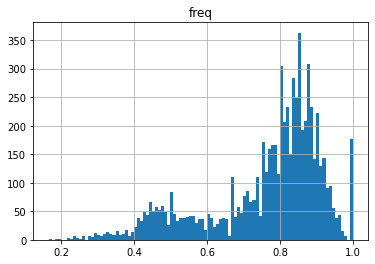

In [9]:
merged_datatop.hist(column='freq', bins=100)
plt.savefig('histogram_abundantBC', dpi=300)

It seems like I can set the threshold at ~0.6

In [10]:
#compute total number of cell BC that are likely singlets
len(merged_datatop.loc[merged_datatop['freq'] > 0.6])/ len(merged_datatop)

0.8220399942454323

In [11]:
#refine list for most dnBC frequency >0.6
merged_datatopthresh = merged_datatop.loc[merged_datatop['freq'] > 0.6]
merged_datatopthresh.to_csv('cellbc_topdnbc_count_dnBCfreq_>0.6.csv')
merged_datatopthresh

,cellBC,dnBC,count,freq
54842,GGCTTGGTCGCTTAAG,ACTGCAGATTTACAGCATGCGCGGTGCTTT,6,1.000000
55224,GGGACTCAGTGAACAT,AGCTGCGTCACCGGGTACATTCGCATTCAC,6,1.000000
53962,GGAGGATTCACTCGAA,TTGGCTAGTTCAGTATGTTTGATGCTATGA,11,1.000000
56581,GGGTTATTCCGGACGT,AGGTCCACTTCATTTTCGGGCTCCGTTAGG,9,1.000000
56804,GGTAATCAGACTACCT,GGTGACCCTTGGAGACTTATTTATGATGCG,14,1.000000
...,...,...,...,...
46674,GAGGCCTGTGTCCGTG,TTTCGTATATTGTCGCCATAGGAGGTTTCT,32,0.603774
75126,TCGAACAAGTACGAGC,ACTGGGTGTCTTCCGCCTTTGGATTTAGGC,35,0.603448
79868,TGATTCTGTAGGCAGT,CTAAGGTGAGCTACGTCACAGGGGATGTAA,35,0.603448
43979,GAATAGACACTCTAGA,TATTCATTTGCGGTGGATTGGCTCGTTTTT,38,0.603175


 === number of BC based on knee point :  6489 

knee filtered cellBCdnBC list stored as : "kneecellBCdnBC.csv"


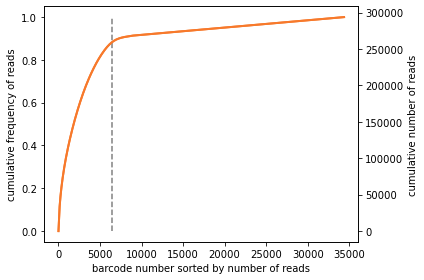

In [12]:
def kneebclib ():
    #BCdf = pd.read_csv('BClibsplit.csv' , names=['upBC', 'dnBC', 'count'])
    BCdf = cellBCdnBCmin
    knBCdf = BCdf.drop(BCdf.columns[[0]], axis=1).sort_values('count', ascending=False).reset_index(drop=True)
    knBCdf['Cumulative Frequency'] = knBCdf['count'].cumsum().reset_index(drop=True)
    knBCdf.index = knBCdf.index + 1
    index = np.array(knBCdf.index + 1)
    cumfrq = np.array(knBCdf['Cumulative Frequency'])
    cumfrqnor = np.array(knBCdf['Cumulative Frequency']/knBCdf['count'].sum())

    xaxis = np.insert(index,0, 0)
    yaxis = np.insert(cumfrqnor,0, 0)
    yaxis2 = np.insert(cumfrq,0, 0)

    kneedle = KneeLocator(xaxis, yaxis, S=1, curve='concave', direction='increasing')
    kneepoint = round(kneedle.knee, 3)

    plt.rcParams.update({'figure.autolayout': True})
    fig, ax = plt.subplots()
    ax2 = ax.twinx()
    ax.plot(xaxis,yaxis, color='#F7792B', linewidth=2.0)
    ax2.plot(xaxis, yaxis2, color='#F7792B', linewidth=2.0)

    print (' === number of BC based on knee point : ', kneepoint, '\n')
    ax.set_xlabel('barcode number sorted by number of reads')  # Add an x-label to the axes.
    ax.set_ylabel('cumulative frequency of reads')  # Add a y-label to the axes.
    ax2.set_ylabel('cumulative number of reads')
    ax.vlines(x=kneepoint, ymin=0, ymax=1,linestyle="dashed", color = 'grey')

    plt.savefig('cumulativekneee.png', format='png', dpi = 200)
    knBClibdf = knBCdf.loc[knBCdf.index[0:kneepoint]].drop(columns ='Cumulative Frequency')
    
    #save knee point filtered list of BCs
    kneecellBCdnBC = cellBCdnBCmin.head(kneepoint)
    kneecellBCdnBC.to_csv('kneecellBCdnBC.csv')
    print('knee filtered cellBCdnBC list stored as : "kneecellBCdnBC.csv"')
    
knBCdf = kneebclib ()